<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
Customers Dataset:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
Products Dataset:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype

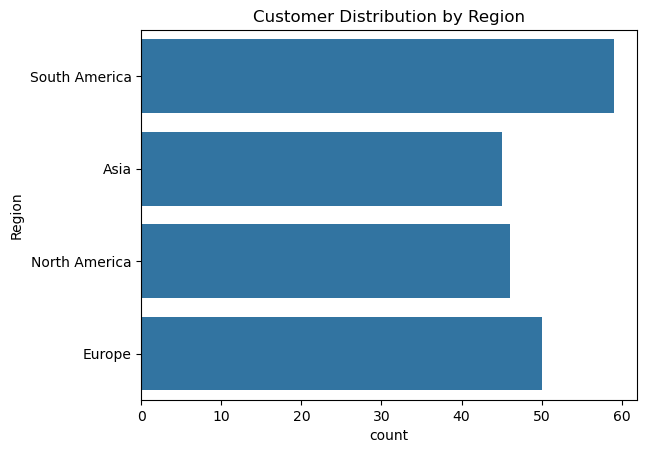

C:\Users\perum\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Davies-Bouldin Index: 0.8311864119437034


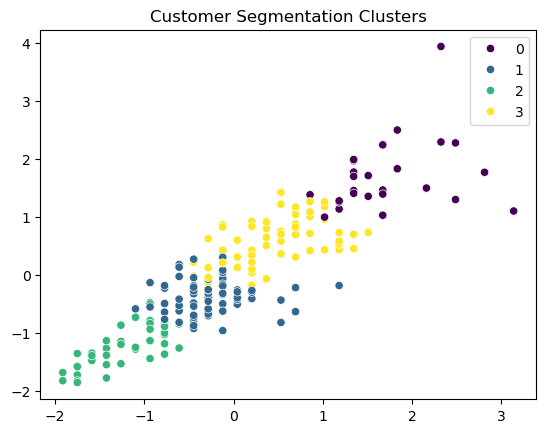


-- EDA Insights --
Total Customers: 200
Total Products: 100
Total Transactions: 1000

Top 5 Customers by Total Purchase Value:
CustomerID
C0141    10673.87
C0054     8040.39
C0065     7663.70
C0156     7634.45
C0082     7572.91
Name: TotalValue, dtype: float64

Top 5 Most Popular Products:
ProductID
P059    46
P054    46
P029    45
P079    43
P061    43
Name: Quantity, dtype: int64

Clusters Summary:
          Quantity   TotalValue        Price
Cluster                                     
0        23.269231  6570.119615  2380.562308
1        10.885714  2769.616714  1128.736143
2         5.146341  1188.462439   535.310976
3        15.467742  4460.843871  1769.357581
EDA, Lookalike Model, and Clustering tasks are completed. Results have been saved.


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

 
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

 
print("Customers Dataset:\n", customers.info())
print("Products Dataset:\n", products.info())
print("Transactions Dataset:\n", transactions.info())

 
sns.countplot(y='Region', data=customers)
plt.title("Customer Distribution by Region")
plt.show()

 
data = pd.merge(transactions, customers, on='CustomerID', how='left')
data = pd.merge(data, products, on='ProductID', how='left')

 
interaction_matrix = data.pivot_table(index='CustomerID', columns='ProductID', values='Quantity', fill_value=0)

 
similarity = cosine_similarity(interaction_matrix)
similarity_df = pd.DataFrame(similarity, index=interaction_matrix.index, columns=interaction_matrix.index)

 
def get_top_lookalikes(customer_id, top_n=3):
    if customer_id not in similarity_df.columns:
        print(f"Customer ID {customer_id} not found in similarity matrix.")
        return pd.Series()
     
    scores = similarity_df[customer_id].sort_values(ascending=False)
     
    top_scores = scores.iloc[1:top_n+1]
    return top_scores

 
lookalikes = {}
for customer in customers['CustomerID'][:20]:
    top_customers = get_top_lookalikes(customer)
    lookalikes[customer] = list(zip(top_customers.index, top_customers.values))

 
lookalike_df = pd.DataFrame.from_dict(lookalikes, orient='index', columns=['Lookalike1', 'Lookalike2', 'Lookalike3'])
lookalike_df.to_csv("Lookalike.csv", index_label="CustomerID")

customer_data = customers.merge(transactions.groupby('CustomerID').sum(numeric_only=True), on='CustomerID')
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data.select_dtypes(include=np.number))

 
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
customer_data['Cluster'] = clusters

 
db_index = davies_bouldin_score(scaled_data, clusters)
print(f"Davies-Bouldin Index: {db_index}")

 
sns.scatterplot(x=scaled_data[:, 0], y=scaled_data[:, 1], hue=clusters, palette='viridis')
plt.title("Customer Segmentation Clusters")
plt.show()

 
customer_data.to_csv("Clustering_Results.csv", index=False)

 
print("\n-- EDA Insights --")
print("Total Customers:", customers.shape[0])
print("Total Products:", products.shape[0])
print("Total Transactions:", transactions.shape[0])

print("\nTop 5 Customers by Total Purchase Value:")
top_customers = transactions.groupby('CustomerID')['TotalValue'].sum().sort_values(ascending=False).head()
print(top_customers)

print("\nTop 5 Most Popular Products:")
popular_products = transactions.groupby('ProductID')['Quantity'].sum().sort_values(ascending=False).head()
print(popular_products)

print("\nClusters Summary:")
print(customer_data.groupby('Cluster').mean(numeric_only=True))

# Final Notes
print("EDA, Lookalike Model, and Clustering tasks are completed. Results have been saved.")
